# Chapter 3: Classification Notes

## 1. MNIST Dataset

In [1]:
# Fetch MNIST digit dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

__Notes on `sklearn` dictionary structure__:
   - `DESCR`: describes dataset
   - `data`: array; one row per instance, one col per feature
   - `target`: array w/labels

In [2]:
# Assign datasets

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

- 70,000 images, 784 features
- 784: $28 \times 28 \times 1$ for BW img

In [4]:
# Can reshape img to 28x28 array and plot with matplotlib

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
y[0] # label should be 5 -- label is a string!

'5'

In [6]:
# Cast y as int

y = y.astype(np.uint8)

In [7]:
# Create train, test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
60000/X.shape[0]

0.8571428571428571

## 2. Training a Binary Classifier

### 2.0 Setup

Start with single-class; consider a '5' classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# Try SGD classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit]) # See if the known 5 is a 5

array([ True])

__Notes on default SGD classifier__ :
   - Uses hinge loss
   - L2 penalty by default
   - Linear classifier

### 2.1 Performance Measures

#### 2.1.1 CV

In [12]:
from sklearn.model_selection import cross_val_score

cv_rmse = cross_val_score(sgd_clf, X_train, y_train_5, scoring = "accuracy", cv = 3)

cv_rmse

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# Note: 5 is only 1/10 of the dataset -- class imbalance!

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy") # naive classifier gets 90% as expected

array([0.91125, 0.90855, 0.90915])

#### 2.1.2 Confusion Matrix

In [15]:
# Leave test set alone for now -- use cross_val_predict() from sklearn

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3) # Returns predictions made on each test fold

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

__Notes on `sklearn` confusion matrix__:
   - Rows = actual, cols = preds
   - First row = negatives, second row = positives

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### 2.1.3 Precision and Recall

$ \mathrm{Precision} = \frac{TP}{TP + FP}$

$ \mathrm{Recall} = \frac{TP}{TP + FN}$ - sensitivity/true positive

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

$F_1 = \frac{2}{ \frac{1}{\mathrm{precision}} + \frac{1}{\mathrm{recall}}}$ = geometric mean

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) # favors classifiers with similar precision and recall

0.7325171197343846

### 2.2 ROC Concepts

#### 2.2.1 Precision vs. Recall

- Can alter decision scores for predictions in SGDClassifier

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [23]:
y_some_digit_pred

array([ True])

In [24]:
# Raise the threshold

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
# Can cross-validate for threshold

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                            method = "decision_function")

In [26]:
# Use this decision threshold analysis to plot the ROC

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

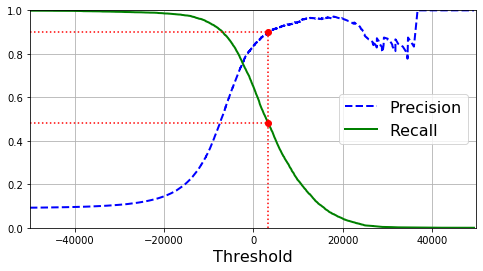

In [27]:
# Use matplot to plot these

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

__Note__ : recall always smoother than precision

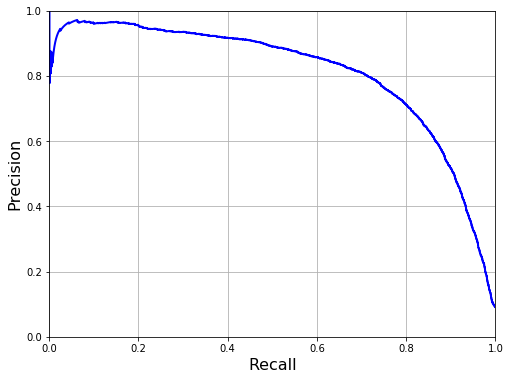

In [28]:
# Another way to view the tradeoff: plot one against the other

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

#### 2.2.2 ROC Curve

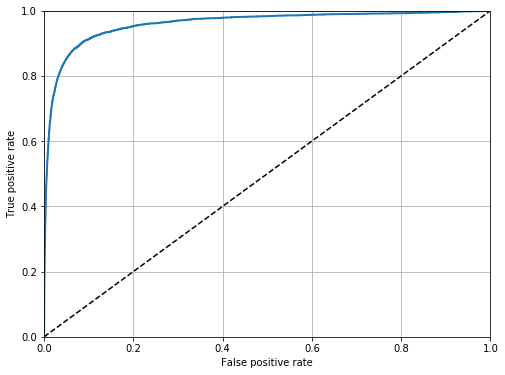

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.grid(True)
    

plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
# AUC score

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

__Notes on F1 vs. AUC__:
   - Prefer $F_1$ when positive class is rare, or when care more about false positives than false negatives
   - Otherwise, ROC probably better

### 2.3 Recap Using Random Forest Classifier

- Random forest DOESN'T have `decision_function()` method -- use `predict_proba()`
- Returns array containing row per instance and column per class, with output probs

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
y_scores_forest = y_probas_forest[:, 1] # prob of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

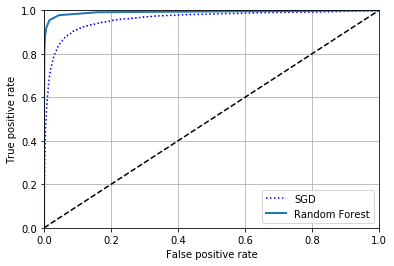

In [33]:
# Plot the ROC curve

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.legend(loc = "lower right")
plt.show() # The random forest wins out here

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## 3. Multiclass Classification

### 3.1 Multiclass notes

- Important to distinguish types of multinomial classifiers

- _Option 1_ : multiclass with native algorithm -- logistic, random forest, naive Bayes

- _Option 2_ : adapt binary classifiers to multiclass
    - __OvR__ (one vs rest) : train K binary classifiers for each class, and select class with highest score across the classifiers
    - __OvO__ (one vs all) : train binary classifier for each class pair ($\frac{K \times (K-1)}{2}$ classifiers!) -- train on smaller sets but more machines
    
- __General notes__ :
    - Better to train SVMs OvO b/c they scale extremely poorly with dataset size
    - OvR preferred for most binary classifiers if this approach needs to be taken

### 3.2 Multiclass with SVM

#### 3.2.1 Basic OvO SVM classification

In [ ]:
# Try SVM multiclass

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # sklearn uses OvO for SVM
svm_clf.predict([some_digit])

C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
# Check the scores

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
# Highest score is for class 5!

np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_ # storage for list of target classes

In [ ]:
svm_clf.classes_[5]

#### 3.2.2 SVM OvR classifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC()) # forces SVC to use OvR
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

#### 3.2.3 SGD multiclass classifier

In [36]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # uses OvR under the hood

array([3], dtype=uint8)

In [37]:
# Decision function returns one value per class

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
# Can evaluate classifier using CV

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [39]:
# Can scale the inputs to increate performance

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

### 3.3 Multiclass Confusion Matrix

In [40]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

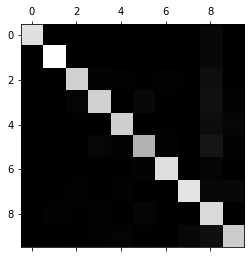

In [41]:
# Can visualize with matplot

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

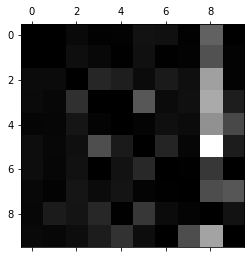

In [42]:
# Scale to show relative error in each block

row_sums = conf_mx.sum(axis = 1, keepdims = True) # normalize by actual classes
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

### 3.4 Error Analysis

In [45]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

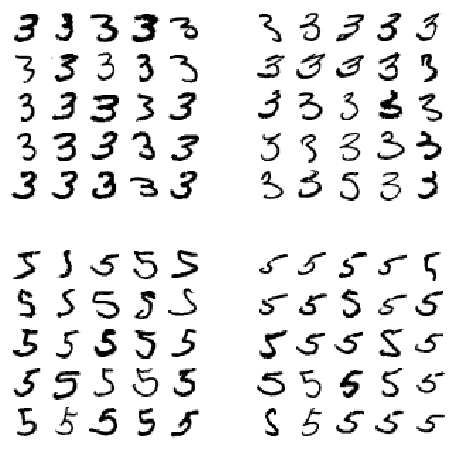

In [46]:
# Plot examples of properly and improperly classified 3's and 5's

cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # true 3 pred 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # true 3 pred 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # true 5 pred 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # true 5 pred 5

# Make the plot

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

__Notes on error__:
   - Used SGD classifier - linear model (weight to each pixel)
   - Hurt by slight shifting and rotation
   - Could also preprocess and center the images to remove this issue if need to use SGD classifier

### 3.5 Multilabel Classification

- Goal: output recognition of multiple classes at once

In [ ]:
# Try KNN multilabel

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # classify if the image is odd and above 7

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
# Make prediction

knn_clf.predict([some_digit])

In [ ]:
# Evaluation is trickier for multilabel
# Here, try average F1 across classes

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro") # average = "weighted" weights score by numer of instances

### 3.6 Multioutput Classification

- Generalization of multilabel where each label can be multiclass

In [ ]:
# Example: "noise removal system" - one output per pixel, each pixel has intensity 0-255

noise = np.random.randint(0, 100, (len(X_train), 784)) # make small random noise
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# Train classifier to clean the image

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## 4. Exercises

### 4.1 KNN Classifier

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()

In [51]:
param_grid = [
    {'weights': ["uniform", "distance"], "n_neighbors" = [3, 4, 5]}
]

Object `KNeighborsClassifier()` not found.


In [ ]:
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, verbose = 3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [57]:
knn_clf_opt = KNeighborsClassifier(weights = 'uniform', n_neighbors = 4)

In [58]:
knn_clf_opt.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
cross_val_score(knn_clf_opt, X_train, y_train, cv = 3, scoring = "accuracy")

### 4.2 Data Augmentation

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28)) # reshape to original dimension
    shifted_image = shift(image, [dy, dx], cval = 0, mode = "constant")
    return shifted_image.reshape([-1])

In [ ]:
# Example application

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

# Plots
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
# Can retrain KNN classifier from here on augmented dataset